In [1]:
import requests
from io import BytesIO
from PIL import Image
import math
import ast

import os

from dotenv import load_dotenv, find_dotenv
load_dotenv(r'../azure-functions/detect-bicycle/.env')

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../azure-functions/src')
from azure_cognitive import _CognitiveService

gis_url = os.getenv('GIS_URL')
gis_username = os.getenv('GIS_USERNAME')
gis_password = os.getenv('GIS_PASSWORD')
feature_service_item_id = os.getenv('SURVEY_LAYER_ITEM_ID')
feature_service_detection_field = os.getenv('FEATURE_SERVICE_DETECTION_FIELD')
feature_service_tags_field = os.getenv('FEATURE_SERVICE_TAGS_FIELD')
azure_key = os.getenv('AZURE_KEY')
azure_region_code = os.getenv('AZURE_REGION_CODE')
tag_search_lst = ast.literal_eval(os.getenv('OBJECT_TAGS'))

In [2]:
class ComputerVision(_CognitiveService):
    """
    Provide interface for working with Azure Computer Vision.
    :param subscription_key: Azure Subscription key for accessing services.
    :param service_url_suffix: Suffix to the base path for accessing specific service.
    :param region_code: URL prefix specifying the region to make calls to.
    """

    def __init__(self, *args):

        # ensure not clobbering parent init
        super().__init__(*args)

        # set the url suffix for this resource
        self._url_suffix = '/vision/v2.0/analyze'

    def _submit_file(self, image_data, params):
        """
        Submit a local file to be recognized.
        :param image: File object to be evaluated.
        """
        # add the header to be able to upload the image
        self.headers['Content-Type'] = 'application/octet-stream'

        # post the request to Azure Cognitive Vision service
        return self.post(self.url, params=params, data=image_data)

    def _get_image_mb(self, image):
        """
        Helper function to quickly get a PIL Image object size in megabytes
        """
        one_mb = 1048576.0
        return len(image.tobytes()) / one_mb

    def _image_oversize(self, image):
        """
        Helper function to assess if an image is oversize for Azure Computer Vision.
        """ 
        oversize_mb = 4
        return self._get_image_mb(image) > oversize_mb

In [3]:
image = 'https://services8.arcgis.com/r5nMFFrM0YYutfJu/arcgis/rest/services/Azure_Bicycle_Detection_view/FeatureServer/0/57/attachments/55'

In [4]:
compvis = ComputerVision(os.getenv('AZURE_KEY'), os.getenv('AZURE_REGION_CODE'))
compvis.url

self = compvis
self.headers['Content-Type'] = 'application/octet-stream'
self.headers

{'Ocp-Apim-Subscription-Key': '6f7aeba065cb4bafa2bd22401779e739',
 'Content-Type': 'application/octet-stream'}

(3911, 2933)
(3793, 2844)
(3679, 2758)
(3568, 2674)
(3460, 2593)
(3356, 2515)
(3255, 2439)
(3157, 2365)
(3062, 2293)
(2970, 2224)
(2880, 2156)
(2793, 2090)
(2709, 2027)
(2627, 1965)
(2548, 1905)
(2471, 1847)
(2396, 1790)
(2324, 1736)
(2254, 1683)
(2186, 1632)
(2120, 1582)
(2056, 1534)
(1994, 1487)
(1934, 1442)
(1875, 1398)
(1818, 1355)
(1763, 1314)
(1710, 1274)
(1658, 1235)
(1608, 1197)
(1559, 1160)
(1512, 1125)
(1466, 1090)
(1422, 1057)
(1379, 1025)
(1337, 993)


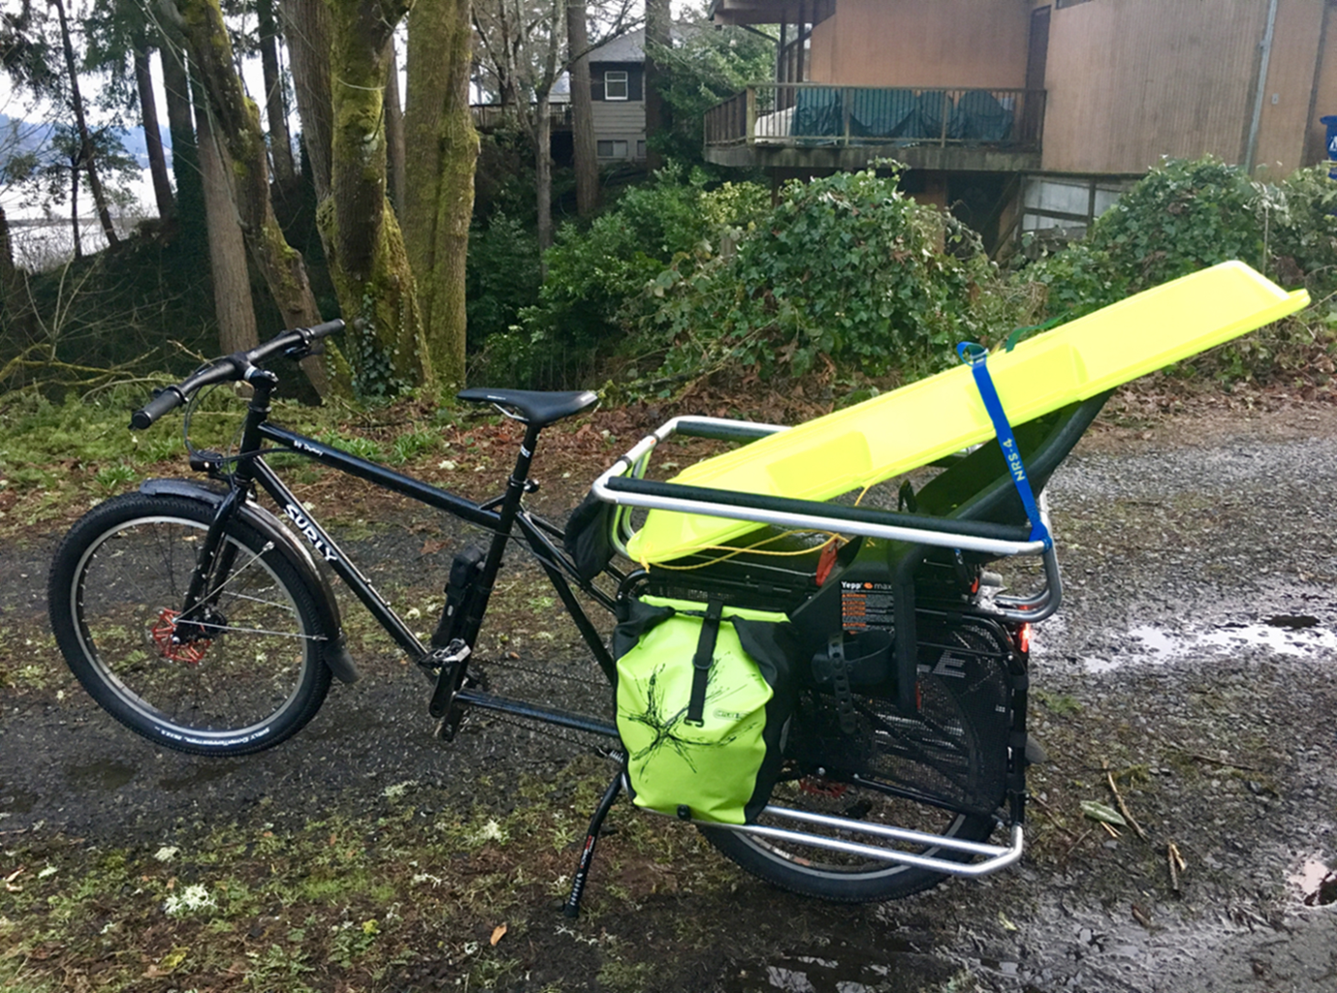

In [18]:
# file size threshold in mb when Computer Vision fails
oversize_mb = 4
one_mb = 1048576.0

# parameters to use as part of the request
params = {'visualFeatures': 'Categories,Description,Color'}

img_resp = requests.get(image, stream=True)
img_resp.raw.decode_content = True
img = Image.open(img_resp.raw)

while self._image_oversize(img):
                    
    # decrease the dimensions of the image by 3%
    img_dimensions = tuple(math.floor(0.97 * val) for val in img.size)
    img.thumbnail(img_dimensions)
    print(img.size)
    
img

In [19]:
resp = self.post(self.url, params=params, data=img.tobytes())
resp.content

b'{"code":"InvalidImageFormat","requestId":"e6ae1d32-717e-4e82-b470-c32907fec879","message":"Input data is not a valid image."}'

In [34]:
from io import BytesIO
file_obj = BytesIO(img.tobytes())

resp = self.post(self.url, params=params, data=file_obj.read())
resp.content

b'{"code":"InvalidImageFormat","requestId":"fb8797f7-5efe-4f42-9ace-10b1dbe53adb","message":"Input data is not a valid image."}'

In [27]:
from tempfile import TemporaryFile

tmp_file = TemporaryFile()
img.save(tmp_file, format='jpeg')

resp = self.post(self.url, params=params, data=tmp_file.read())
resp.content

b'{"code":"InvalidImageFormat","requestId":"a97fa1d0-7d01-4dba-b5f8-3b80de189bc5","message":"Input data is not a valid image."}'

In [35]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
img_file = os.path.join(tmp_dir.name, 'tmp_file.jpg')
img.save(img_file, format='jpeg')

resp = self.post(self.url, params=params, data=open(img_file, 'rb').read())
resp.content

b'{"categories":[{"name":"trans_bicycle","score":0.9921875}],"color":{"dominantColorForeground":"Grey","dominantColorBackground":"Grey","dominantColors":["Grey","Black"],"accentColor":"ADBE0D","isBwImg":false,"isBWImg":false},"description":{"tags":["outdoor","grass","bicycle","building","parked","sitting","sidewalk","bench","front","yellow","park","green","leaning","street","wooden","standing","seat","man","red","sign","brick","blue"],"captions":[{"text":"a bicycle parked in front of a building","confidence":0.894441114906353}]},"requestId":"5472f1b9-990a-4844-9d16-4966029fde8a","metadata":{"width":1337,"height":993,"format":"Jpeg"}}'